# **LLM - Arxiv - HF**

## **STEPS TO FOLLOW**

**Q&A**: You have to download a dataset from HF, choose a pre-processing (if you want to do it, otherwise not), choose 2 models, and fine-tune this task. One fine-tuning has to be done without using LoRa, while the other has to be done using LoRa and everything has to run within the Colab limits.

**Datasets**: News Q&A, MED Q&A, Arxiv Q&A. Choose the dataset you like the most.

**Metrics**: Plots of the training and validation loss (maybe it is useful to use wandb, but it’s your choice).

## **Setting up the enviroment**

In [1]:
# Set to True the first time you run this file to install the required packages
install_packages = False
if install_packages:
    %pip install -q bitsandbytes datasets accelerate loralib transformers wandb peft

### **Import packages and functions**

In [ ]:
from datasets import load_dataset
from huggingface_hub import login
import transformers

login('***********')

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to /root/.cache/huggingface/token
Login successful


## **Load and Analyze Dataset**

In [ ]:
# Load data from Hugging Face
dataset = load_dataset('taesiri/arxiv_qa')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/210580 [00:00<?, ? examples/s]

In [ ]:
# Print the dataset structure
dataset

DatasetDict({
    train: Dataset({
        features: ['paper_id', 'model', 'question', 'answer'],
        num_rows: 210580
    })
})

In [ ]:
# Print an 'answer' in 'train' in dataset
dataset['train']['answer'][:1]

[' Based on my reading of the paper, the main research questions/hypotheses appear to be:\n\n- Can neural network models achieve state-of-the-art performance on a variety of natural language processing tasks, including part-of-speech tagging, chunking, named entity recognition, and semantic role labeling? \n\n- Can a single neural network architecture handle all of these tasks with minimal task-specific adaptation?\n\n- Will neural network models utilizing only raw textual input and minimal linguistic preprocessing outperform traditional models relying heavily on hand-engineered features?\n\nThe authors propose using a single multi-layer neural network architecture called SENNA that utilizes word embeddings as input and can be trained on different NLP tasks. They systematically evaluate SENNA on several benchmark datasets across the tasks mentioned above and compare its performance to state-of-the-art systems, demonstrating that their model achieves excellent results on all tasks while

## **Model (with LoRa)**

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import torch
import torch.nn as nn
from transformers import AutoTokenizer, AutoModelForCausalLM

model = AutoModelForCausalLM.from_pretrained(
    "facebook/opt-6.7b",
    load_in_4bit=True,
    device_map='auto',
)

tokenizer = AutoTokenizer.from_pretrained("facebook/opt-6.7b")
tokenizer.pad_token = tokenizer.eos_token

config.json:   0%|          | 0.00/651 [00:00<?, ?B/s]

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


pytorch_model.bin.index.json:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

pytorch_model-00001-of-00002.bin:   0%|          | 0.00/9.96G [00:00<?, ?B/s]

pytorch_model-00002-of-00002.bin:   0%|          | 0.00/3.36G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/685 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/441 [00:00<?, ?B/s]

In [ ]:
model

OPTForCausalLM(
  (model): OPTModel(
    (decoder): OPTDecoder(
      (embed_tokens): Embedding(50272, 4096, padding_idx=1)
      (embed_positions): OPTLearnedPositionalEmbedding(2050, 4096)
      (final_layer_norm): LayerNorm((4096,), eps=1e-05, elementwise_affine=True)
      (layers): ModuleList(
        (0-31): 32 x OPTDecoderLayer(
          (self_attn): OPTAttention(
            (k_proj): Linear4bit(in_features=4096, out_features=4096, bias=True)
            (v_proj): Linear4bit(in_features=4096, out_features=4096, bias=True)
            (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=True)
            (out_proj): Linear4bit(in_features=4096, out_features=4096, bias=True)
          )
          (activation_fn): ReLU()
          (self_attn_layer_norm): LayerNorm((4096,), eps=1e-05, elementwise_affine=True)
          (fc1): Linear4bit(in_features=4096, out_features=16384, bias=True)
          (fc2): Linear4bit(in_features=16384, out_features=4096, bias=True)
          

### **Pre-processing**

In [ ]:
pandas_format = dataset['train'].to_pandas()
display(pandas_format.head())

,paper_id,model,question,answer
0,1510.00726,claude-2.0,What is the central research question or hypot...,"Based on my reading of the paper, the main re..."
1,1510.00726,claude-2.0,What is the main contribution of this paper?,"Based on the abstract, it appears this paper ..."
2,1510.00726,claude-2.0,How does this paper compare to other research ...,Here are my thoughts on how this paper compar...
3,1510.00726,claude-2.0,What future research directions do the authors...,"Based on my reading of the paper, some of the..."
4,1510.00726,claude-2.0,Summarize the paper in one paragraph.,Here is a one paragraph summary of the paper:...


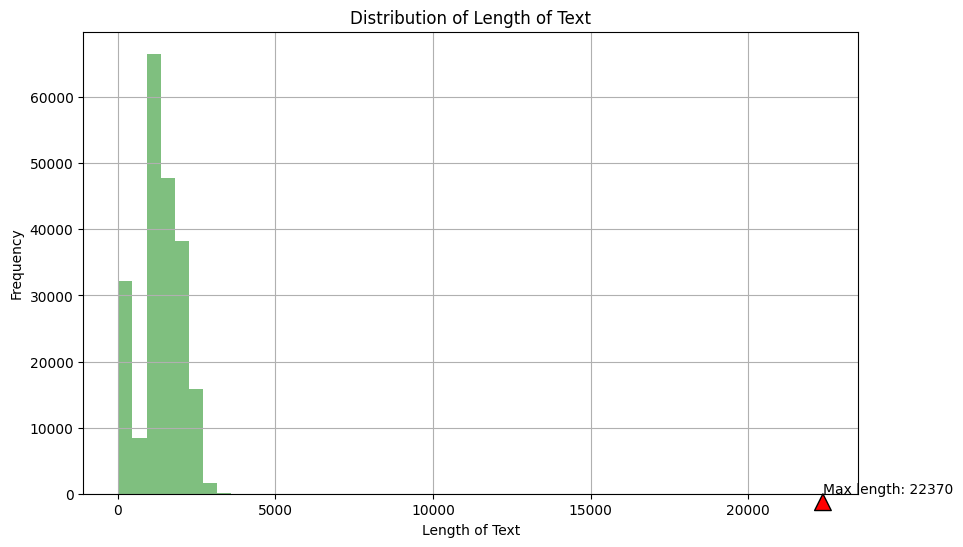

In [ ]:
import matplotlib.pyplot as plt

pandas_format['text_length'] = pandas_format['answer'].apply(len)

max_length = pandas_format['text_length'].max()

plt.figure(figsize=(10,6))
plt.hist(pandas_format['text_length'], bins=50, alpha=0.5, color='g')

plt.annotate('Max length: {}'.format(max_length), xy=(max_length, 0), xytext=(max_length, 50),
             arrowprops=dict(facecolor='red', shrink=0.05))

plt.title('Distribution of Length of Text')
plt.xlabel('Length of Text')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [ ]:
dataset = dataset.map(lambda samples: tokenizer(samples['answer'], padding="max_length", truncation=True), batched=True)
dataset = dataset.filter(lambda example: 100 <= len(example["answer"]) <= 3500)

Map:   0%|          | 0/210580 [00:00<?, ? examples/s]

Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Filter:   0%|          | 0/210580 [00:00<?, ? examples/s]

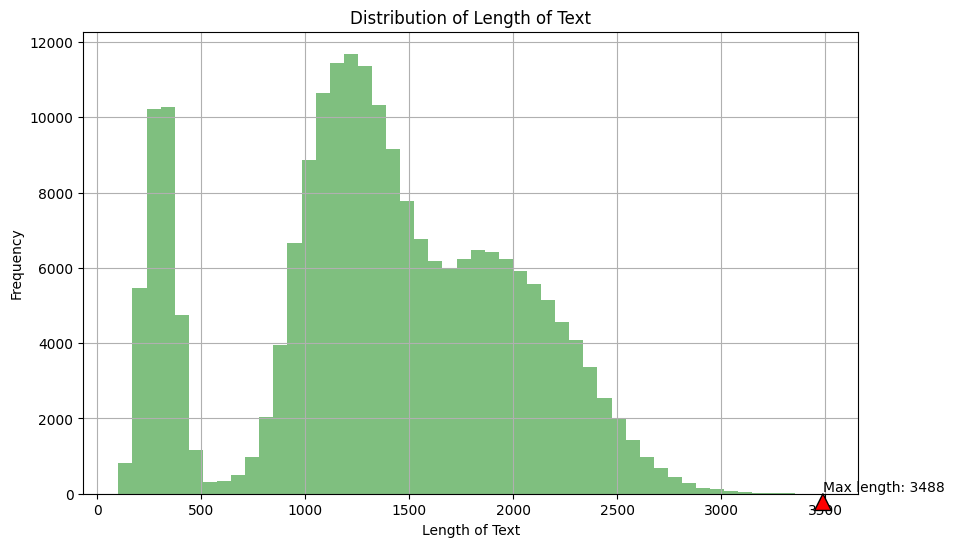

In [ ]:
import matplotlib.pyplot as plt

pandas_format = dataset['train'].to_pandas()

pandas_format['text_length'] = pandas_format['answer'].apply(len)

max_length = pandas_format['text_length'].max()

plt.figure(figsize=(10,6))
plt.hist(pandas_format['text_length'], bins=50, alpha=0.5, color='g')

plt.annotate('Max length: {}'.format(max_length), xy=(max_length, 0), xytext=(max_length, 50),
             arrowprops=dict(facecolor='red', shrink=0.05))

plt.title('Distribution of Length of Text')
plt.xlabel('Length of Text')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [ ]:
small_train_dataset = dataset["train"].shuffle(seed=42).select(range(1000))
small_eval_dataset = dataset["train"].shuffle(seed=42).select(range(1000))

### **Training (with LoRa)**

In [ ]:
for param in model.parameters():
  param.requires_grad = False  # freeze the model - train adapters later
  if param.ndim == 1:
    # cast the small parameters (e.g. layernorm) to fp32 for stability
    param.data = param.data.to(torch.float32)

model.gradient_checkpointing_enable()  # reduce number of stored activations
model.enable_input_require_grads()

class CastOutputToFloat(nn.Sequential):
  def forward(self, x): return super().forward(x).to(torch.float32)
model.lm_head = CastOutputToFloat(model.lm_head)

In [ ]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["q_proj", "v_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

model = get_peft_model(model, config)

Train:

In [ ]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
trainer = transformers.Trainer(
    model=model,
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,

    args=transformers.TrainingArguments(
        per_device_train_batch_size=4,
        gradient_accumulation_steps=4,
        warmup_steps=100,
        max_steps=300,  # more or less two epochs across all the dataset
        learning_rate=2e-4,
        # the model is actually stored in 8 bits, but at each layer the weights
        # are upcasted to 16 bits, then downcasted again to 8 bits.
        fp16=True,
        do_eval=True,
        evaluation_strategy="steps",
        eval_steps=50,
        logging_steps=5,
        output_dir='outputs',
        report_to="wandb"
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False)
)
model.config.use_cache = False  # silence the warnings. Please re-enable for inference!

wandb.init(project="fine-tuning-arxiv", name="lora-fine-tuning")
trainer.train()
wandb.finish()

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
max_steps is given, it will override any value given in num_train_epochs
wandb: Currently logged in as: pasquale-sapienza (organization-pasquale). Use `wandb login --relogin` to force relogin


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
/usr/local/lib/python3.10/dist-packages/bitsandbytes/nn/modules.py:426: UserWarning: Input type into Linear4bit is torch.float16, but bnb_4bit_compute_dtype=torch.float32 (default). This will lead to slow inference or training speed.
  warnings.warn(


Step,Training Loss,Validation Loss
50,2.567500,2.442033
100,2.463700,2.281929
150,2.303100,2.212893
200,2.205500,2.167403
250,2.280200,2.131485
300,2.160500,2.116433


eval/loss,█▅▃▂▁▁
eval/runtime,▇▃█▄▂▁
eval/samples_per_second,▂▅▁▄▇█
eval/steps_per_second,▁█▁███
train/epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
train/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
train/grad_norm,▂▂▂▁▂▂▃▁▃▃▃▂▃▃▃▂▄▁▂▃▅▃▂▃▃▃▄▃▅▃▆▅▇▅▄▅█▅█▃
train/learning_rate,▁▂▂▃▃▄▅▅▆▆▇▇███▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▃▃▃▃▂▂▂▂▁▁
train/loss,█▇▆▇▆▆▅▆▄▄▃▄▃▄▃▃▃▃▂▃▂▂▂▂▂▂▂▁▂▂▂▃▂▂▂▁▂▁▂▁
eval/loss,2.11643
eval/runtime,388.2388


## **Model (without LoRa)**

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import torch
import torch.nn as nn
import bitsandbytes as bnb
from transformers import AutoTokenizer, AutoConfig, AutoModelForCausalLM

model = AutoModelForCausalLM.from_pretrained(
    "BAAI/bge-reranker-base",
)

tokenizer = AutoTokenizer.from_pretrained("BAAI/bge-reranker-base")

config.json:   0%|          | 0.00/799 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

If you want to use `XLMRobertaLMHeadModel` as a standalone, add `is_decoder=True.`
Some weights of XLMRobertaForCausalLM were not initialized from the model checkpoint at BAAI/bge-reranker-base and are newly initialized: ['lm_head.bias', 'lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/443 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/279 [00:00<?, ?B/s]

In [ ]:
model

XLMRobertaForCausalLM(
  (roberta): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
  

### **Pre-processing**

In [ ]:
pandas_format = dataset['train'].to_pandas()
display(pandas_format.head())

,paper_id,model,question,answer
0,1510.00726,claude-2.0,What is the central research question or hypot...,"Based on my reading of the paper, the main re..."
1,1510.00726,claude-2.0,What is the main contribution of this paper?,"Based on the abstract, it appears this paper ..."
2,1510.00726,claude-2.0,How does this paper compare to other research ...,Here are my thoughts on how this paper compar...
3,1510.00726,claude-2.0,What future research directions do the authors...,"Based on my reading of the paper, some of the..."
4,1510.00726,claude-2.0,Summarize the paper in one paragraph.,Here is a one paragraph summary of the paper:...


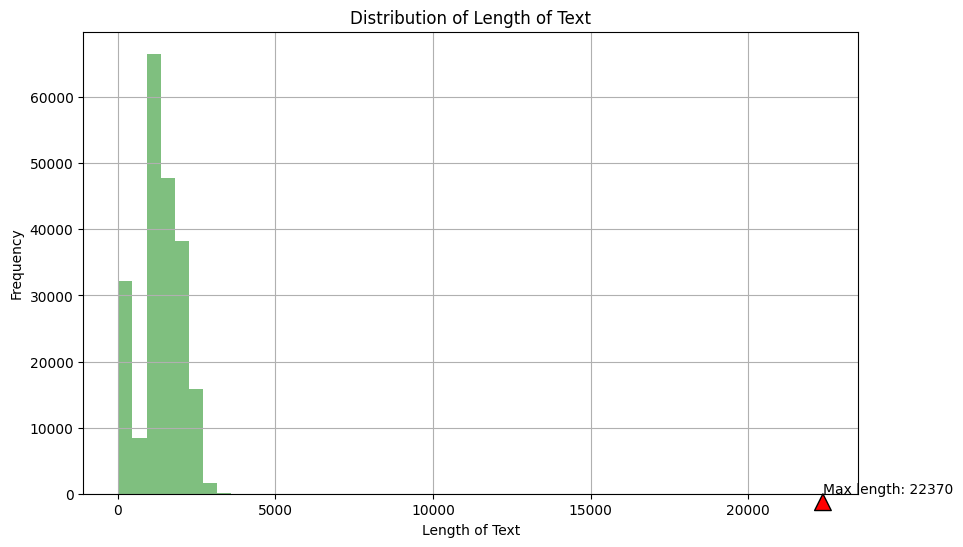

In [ ]:
import matplotlib.pyplot as plt

pandas_format['text_length'] = pandas_format['answer'].apply(len)

max_length = pandas_format['text_length'].max()

plt.figure(figsize=(10,6))
plt.hist(pandas_format['text_length'], bins=50, alpha=0.5, color='g')

plt.annotate('Max length: {}'.format(max_length), xy=(max_length, 0), xytext=(max_length, 50),
             arrowprops=dict(facecolor='red', shrink=0.05))

plt.title('Distribution of Length of Text')
plt.xlabel('Length of Text')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [ ]:
dataset = dataset.map(lambda samples: tokenizer(samples['answer'], padding="max_length", truncation=True), batched=True)
dataset = dataset.filter(lambda example: 100 <= len(example["answer"]) <= 3500)

Map:   0%|          | 0/210580 [00:00<?, ? examples/s]

Filter:   0%|          | 0/210580 [00:00<?, ? examples/s]

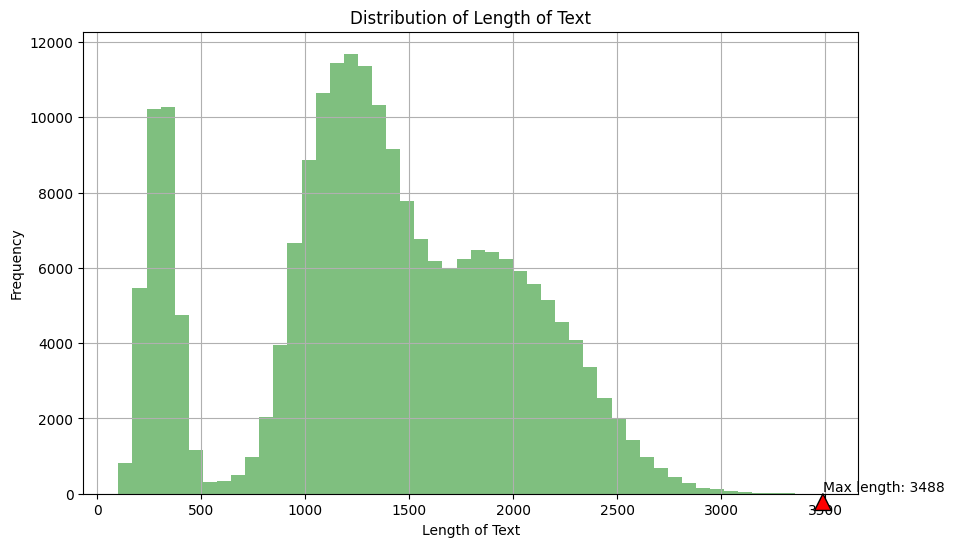

In [ ]:
import matplotlib.pyplot as plt

pandas_format = dataset['train'].to_pandas()

pandas_format['text_length'] = pandas_format['answer'].apply(len)

max_length = pandas_format['text_length'].max()

plt.figure(figsize=(10,6))
plt.hist(pandas_format['text_length'], bins=50, alpha=0.5, color='g')

plt.annotate('Max length: {}'.format(max_length), xy=(max_length, 0), xytext=(max_length, 50),
             arrowprops=dict(facecolor='red', shrink=0.05))

plt.title('Distribution of Length of Text')
plt.xlabel('Length of Text')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [ ]:
small_train_dataset = dataset["train"].shuffle(seed=42).select(range(1000))
small_eval_dataset = dataset["train"].shuffle(seed=42).select(range(1000))

### **Training (without LoRa)**

In [ ]:
for param in model.parameters():
  param.requires_grad = False  # freeze the model - train adapters later
  if param.ndim == 1:
    # cast the small parameters (e.g. layernorm) to fp32 for stability
    param.data = param.data.to(torch.float32)

model.gradient_checkpointing_enable()  # reduce number of stored activations
model.enable_input_require_grads()

class CastOutputToFloat(nn.Sequential):
  def forward(self, x): return super().forward(x).to(torch.float32)
model.lm_head = CastOutputToFloat(model.lm_head)

In [ ]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
trainer = transformers.Trainer(
    model=model,
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,

    args=transformers.TrainingArguments(
        per_device_train_batch_size=4,
        gradient_accumulation_steps=4,
        warmup_steps=100,
        max_steps=300,  # more or less two epochs across all the dataset
        learning_rate=2e-4,
        # the model is actually stored in 8 bits, but at each layer the weights
        # are upcasted to 16 bits, then downcasted again to 8 bits.
        bf16=True,
        do_eval=True,
        evaluation_strategy="steps",
        eval_steps=50,
        logging_steps=5,
        output_dir='outputs',
        report_to="wandb"
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False)
)
model.config.use_cache = False  # silence the warnings. Please re-enable for inference!

wandb.init(project="fine-tuning-arxiv", name="noLoRa-fine-tuning")
trainer.train()
wandb.finish()

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
max_steps is given, it will override any value given in num_train_epochs
wandb: Currently logged in as: pasquale-sapienza (organization-pasquale). Use `wandb login --relogin` to force relogin


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Step,Training Loss,Validation Loss
50,24.144000,24.203381
100,24.227600,24.203381
150,24.203800,24.203381
200,24.246100,24.203381
250,24.124000,24.203381
300,24.130000,24.203381


eval/loss,▁▁▁▁▁▁
eval/runtime,█▅▅▁▃▅
eval/samples_per_second,▁▄▄█▆▄
eval/steps_per_second,▁▆▃█▆▃
train/epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
train/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
train/grad_norm,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/learning_rate,▁▂▂▃▃▄▅▅▆▆▇▇███▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▃▃▃▃▂▂▂▂▁▁
train/loss,▂▆▃▁▅▄▃▅▄▃▄▄▅▆▅▂▃▃▃▃▂█▃▆▂▆▆▂▅▅▄▄▁▂▂▅▄▂▄▃
eval/loss,24.20338
eval/runtime,135.2084


## **URL Workspace wandb**

https://wandb.ai/organization-pasquale/fine-tuning-arxiv?nw=nwuserpasqualesapienza

## Theory

**1. You have an LLM that generates text and you want to generate the word Ferrari within a sentence. How can you do this? Answer on both practical and theoretical aspects.**

**Answer:**
- Practical Aspect: Use a prompting technique by providing a partial sentence or context that leads the model to generate the word “Ferrari”. For example, “My dream car is a…”
- Theoretical Aspect: Language models generate text based on learned probabilities from training data. By crafting a prompt that aligns with contexts where “Ferrari” is likely to appear, we guide the model’s output towards including the desired word.

**2. How might biases in training data affect the output of LLMs, and what strategies can be employed to mitigate these biases?**

**Answer:**
- Impact on Output: Biases in training data can lead to skewed or discriminatory outputs, reflecting the prejudices present in the data.
- Mitigation Strategies: Techniques such as data augmentation, debiasing algorithms, and using diverse and representative training datasets can help mitigate these biases. Additionally, implementing fairness-aware training objectives and post-processing corrections are effective strategies.